<a href="https://colab.research.google.com/github/rmcpantoja/My-Colab-Notebooks/blob/main/notebooks/OpenAI%20Whisper%20-%20DotCSV%20(Speech%20dataset%20multi-transcryption%20support)en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🗣️ <font color="B19CD9">**Whisper + Whisper X**
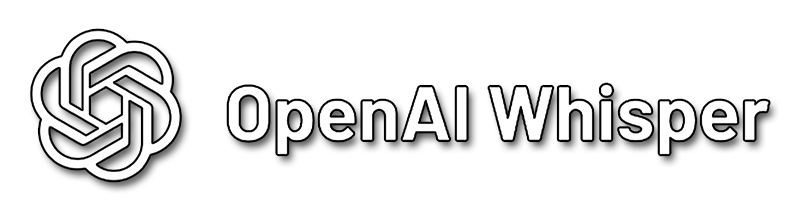

---
**[Original Notebook](https://colab.research.google.com/drive/1CvvYPAFemIZdSOt9fhN541esSlZR7Ic6) created by [DotCSV](https://www.youtube.com/channel/UCy5znSnfMsDwaLlROnZ7Qbg)**
* Modified by [rmcpantoja](http://github.com/rmcpantoja), with the purpose of implementing support for audio datasets and transcriptions compatible for training with speech synthesizers.
* Decorated by [Xx_Nessu_xX](https://github.com/XxNessuxX)

🚨 <font color="orange">Have **Hardware acceleration** with GPU enabled in `"Runtime environment" > "Change type of runtime environment"`.

In [ ]:
#@title ## <font color="B19CD9">**Execute this cell to install the libraries.** ⚙️

#@markdown ---
#@markdown ### Now we have Whisper X, it is much faster and more efficient than normal Whisper. Also the normal one is still available.
#@markdown ---
#@markdown <font color="orange">**Note: Please restart the runtime environment if prompted and, after restarting, run this cell again and continue with the others.**
"""
To write this piece of code I took inspiration/code from a lot of places.
It was late night, so I'm not sure how much I created or just copied o.O
Here are some of the possible references:
https://blog.addpipe.com/recording-audio-in-the-browser-using-pure-html5-and-minimal-javascript/
https://stackoverflow.com/a/18650249
https://hacks.mozilla.org/2014/06/easy-audio-capture-with-the-mediarecorder-api/
https://air.ghost.io/recording-to-an-audio-file-using-html5-and-js/
https://stackoverflow.com/a/49019356
"""
!mkdir /content/wavs
software = "whisperX" #@param ["whisper", "whisperX"]
if software == "whisper":
    !pip install git+https://github.com/openai/whisper.git
    !pip install ffmpeg
else:
    !pip install git+https://github.com/m-bain/whisperX
!pip install jiwer
!pip install --upgrade natsort num2words
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
#@title ## <font color="B19CD9">**Mount your Google Drive. 📂**
#@markdown ---
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# <font color="B19CD9">***Configuration.*** ⚙️

In [ ]:
#@title ## <font color="B19CD9">**Extract dataset. (.zip or similar)** 📥
#@markdown ---
wavs_path = "/content/drive/MyDrive/wavs.zip" #@param {type: "string"}
import zipfile
import os
if os.listdir('/content/wavs/'):
  !rm /content/wavs/*.
%cd /content/wavs
if not os.path.exists(wavs_path):
  raise Exception("The audio path is not correct.").
if not zipfile.is_zipfile(wavs_path):
  raise Exception("This is not a compressed (zip) file.")
print("Extracting audios...")
!unzip -j -q "$wavs_path" -d /content/wavs
print("Extraction finished.")

In [ ]:
#@title ## <font color="B19CD9">**Begin transcription of all loaded audios.** 📝
#@markdown ---
#@markdown *It is strongly recommended to check for warnings. These mostly tend to be for extra words that may harm the dataset.*
#@markdown #### Size of model to use:
model = "large-v2" #@param ["medium", "large", "large-v2"]
#@markdown ---
#@markdown #### Choose the processing batch size (WhisperX only):
batch_size = 32 # @param {type:"integer"}
transcriptionFiles = "/content/lists"
sentence_warns = ["¡Suscribete al canal!", "Subtítulos por la comunidad de"]
%cd /content/wavs
import os
import num2words
from natsort import os_sorted
def convert_num_to_words(utterance):
    utterance = ' '.join([num2words.num2words(i ,lang='en') if i.isdigit() else i for i in utterance.split()])
    return utterance

print("Getting files...")
# folder path
dir_path = '/content/wavs'

# list to store files
filelist = ''
files = []
# Iterate directory
for path in os_sorted(os.listdir(dir_path)):
    # check if current path is a file
    if os.path.isfile(os.path.join(dir_path, path)):
        filelist += '"'+path+'"  '
        files.append(path)
#print(files)
print("Transcribing...")
if software == "whisper":
    !whisper {filelist} --task transcribe --model $model --language en --verbose False --output_dir {transcriptionFiles}
else:
    !whisperx {filelist} --task transcribe --model $model --language en --verbose False --output_dir {transcriptionFiles} --batch_size {batch_size}
print("Storing all transcripts (list.txt)")
newlist = open("/content/list.txt", "w")
for filename in files:
  transcription = open(transcriptionFiles+"/"+filename[:-4]+".txt", "r")
  text = transcription.read()
  text = text.strip()
  text = text.replace('\n', ' ')
  text = convert_num_to_words(text)
  for badsentence in sentence_warns:
    if badsentence in text:
    print(f "Warning! The following extra text has been added. This is often a problem when working with the data set. Line where you will find: {filename}. Phrase: {text}")
  transcription.close
  newlist.write("wavs/"+filename+"|"+text+"\n")
newlist.close()
print("List created!")

In [ ]:
#@title ## <font color="B19CD9">**Download transcript?** 📥
#@markdown ---
#@markdown Execute this cell if you want to download the list.txt file generated with the transcripts.from google.colab import files
files.download('/content/list.txt')

## <font color="red">**Delete dataset.** 🗑️

---

Execute this cell if you want to delete the current dataset and transcribe another one.

In [ ]:
!rm -r /content/wavs/* /content/lists /content/list.txt